# Статистические тесты и анализ данных
### Содержание
1. Введение и подготовка
2. Центральная предельная теорема (ЦПТ) и доверительные интервалы
3. Статистические тесты в SciPy
4. О смысле p-value, корректности и мощности
5. Перестановочные тесты
6. Bootstrap
7. Бакетное сэмплирование

## 1. Введение и подготовка

В этом блокноте мы рассмотрим различные статистические методы и их применение для анализа данных.  
Начнем с импорта необходимых библиотек:

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats

%matplotlib inline

plt.style.available
plt.style.use('seaborn-v0_8')

Сгенерируем данные с одинаковыми средними - берем выборки из нормального распределения с одиноковым средним

In [2]:
data_fst = np.random.normal(10, 10, size=100)
data_snd = np.random.normal(10, 1, size=100)

Если мы посмотрим на средние значения выборок, то они конечно же будут различны

In [3]:
print("Средние значения выборок:")
print(data_fst.mean())
print(data_snd.mean())

Средние значения выборок:
9.41458656073517
10.100501594627659


Визуализация распределений:

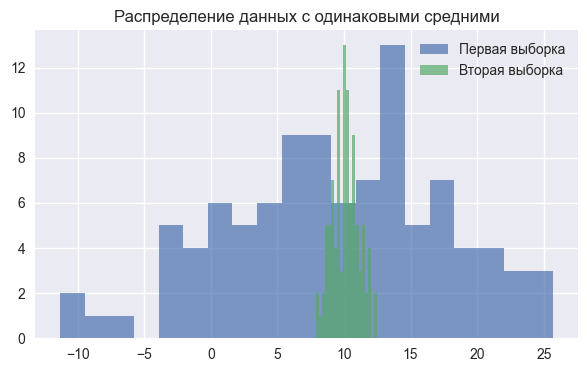

In [4]:
plt.figure(figsize=(7, 4))
plt.hist(data_fst, bins=20, alpha=0.7, label='Первая выборка')
plt.hist(data_snd, bins=20, alpha=0.7, label='Вторая выборка')
plt.title('Распределение данных с одинаковыми средними')
plt.legend()
plt.show()

Но если средние распределения, откуда берем выборки разные, то числа в выборках тоже могут не сильно отличаться

In [5]:
data_fst = np.random.normal(10.5, 10, size=100)
data_snd = np.random.normal(10, 1, size=100)

print("Средние значения выборок:")
print(data_fst.mean())
print(data_snd.mean())

Средние значения выборок:
12.69974705274943
10.004783729327697


In [6]:
print("5 элементов из каждой выборки:")
print(data_fst[:5])
print(data_snd[:5])

5 элементов из каждой выборки:
[24.28741572  8.32661098 29.37807169  9.21341616  3.66207331]
[10.12762587 10.68050696 10.94000301  9.04294328 10.88950926]


Визуализация распределений:

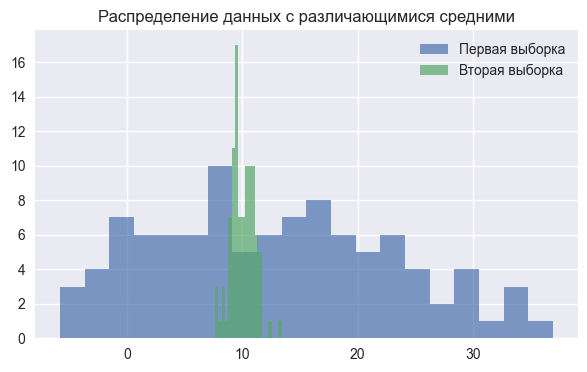

In [7]:
plt.figure(figsize=(7, 4))
plt.hist(data_fst, bins=20, alpha=0.7, label='Первая выборка')
plt.hist(data_snd, bins=20, alpha=0.7, label='Вторая выборка')
plt.title('Распределение данных с различающимися средними')
plt.legend()
plt.show()

## 2. Использование ЦПТ и доверительные интервалы

### Можно воспользоваться ЦПТ и получить доверительный интервал для среднего

____
#### Напоминание ЦПТ:
Пусть $\xi_1, \xi_2, \dots$ - независимые одинаково распределённые случайные величины с конечной дисперсией $D \xi_1$ и мат. ожиданием $E \xi_1$, тогда

$\sqrt{\frac{n}{D \xi_1}} \left(\frac{\sum\limits_{i=1}^{n} \xi_i}{n} - E \xi_1\right) \to_{n \to \infty} \mathcal{N}(0, 1)$ 

Отсюда можно сделать вывод, что при больших $n$ величина $\frac{\sum\limits_{i=1}^{n} \xi_i}{n}$ будет распределена примерно как $\mathcal{N}(E \xi_1, \frac{D \xi_1}{n})$

Если бы мы знали $D \xi_1$, то отсюда можно получить интервал на $E \xi_1$:
$$
P\left(E \xi_1 \in \left[\frac{\sum\limits_{i=1}^{n} \xi_i}{n} - 1.96 \sqrt{\frac{D \xi_1}{n}}, \frac{\sum\limits_{i=1}^{n} \xi_i}{n} + 1.96 \sqrt{\frac{D \xi_1}{n}}\right]\right) \approx 0.95
$$

$D \xi_1$ можно оценить по выборке
_____

Так, используя ЦПТ, мы можем построить доверительный интервал для среднего значения.  
Реализуем функцию для вычисления 95% доверительного интервала:

In [8]:
def get_95_interval(data, sigma=None):
    mean = data.mean()
    if sigma is None:
        sigma = data.std()
    err = sigma * 1.96 / np.sqrt(len(data))
    return mean - err, mean + err

### Проверка корректности доверительного интервала

Проверим, действительно ли наш доверительный интервал содержит истинное среднее значение в 95% случаев:
Сделаем 10 тыс. симуляций, в каждой возьмем случайную выборку, посчитаем выборочное среднее и его доверительный интервал, после чего посмотрим, попадает ли истинное среднее в него. В итоге посмотрим, в каком % симуляций истинное среднее попало в ДИ

In [9]:
hits = 0.
count = 0.
true_mean = 10.

for _ in range(10000):
    data = np.random.normal(true_mean, 10, size=100)
    lower_bound, upper_bound = get_95_interval(data)
    count += 1
    if lower_bound <= true_mean <= upper_bound:
        hits += 1
        
print(f"Доля случаев, когда интервал содержит истинное среднее: {hits / count:.4f}")

Доля случаев, когда интервал содержит истинное среднее: 0.9419


Однако, если наблюдений в выборке будет мало, то оценка будет неправильна:

In [10]:
hits = 0.
count = 0.
true_mean = 10.

for _ in range(10000):
    data = np.random.normal(true_mean, 10, size=10)
    lower_bound, upper_bound = get_95_interval(data)
    count += 1
    if lower_bound <= true_mean <= upper_bound:
        hits += 1
        
print(f"Доля случаев, когда интервал содержит истинное среднее: {hits / count:.4f}")

Доля случаев, когда интервал содержит истинное среднее: 0.9047


Подставим истинное значение стандартного отклонения вместо оценочного по выборке и всё снова заработает (однако на практике мы можем не знать истинного значения):

In [11]:
hits = 0.
count = 0.
true_mean = 10.

for _ in range(10000):
    data = np.random.normal(true_mean, 10, size=10)
    lower_bound, upper_bound = get_95_interval(data, sigma=10)
    count += 1
    if lower_bound <= true_mean <= upper_bound:
        hits += 1
        
print(f"Доля случаев, когда интервал содержит истинное среднее: {hits / count:.4f}")

Доля случаев, когда интервал содержит истинное среднее: 0.9541


### Сравнение ДИ выборок

Итак, у нас две выборки с гигантской разницей в среднем (10.5 и 100):

95% доверительный интервал для среднего первой выборки: (10.83298611162083, 14.444968347151214)
95% доверительный интервал для среднего второй выборки: (99.90239253901534, 100.31140433790877)


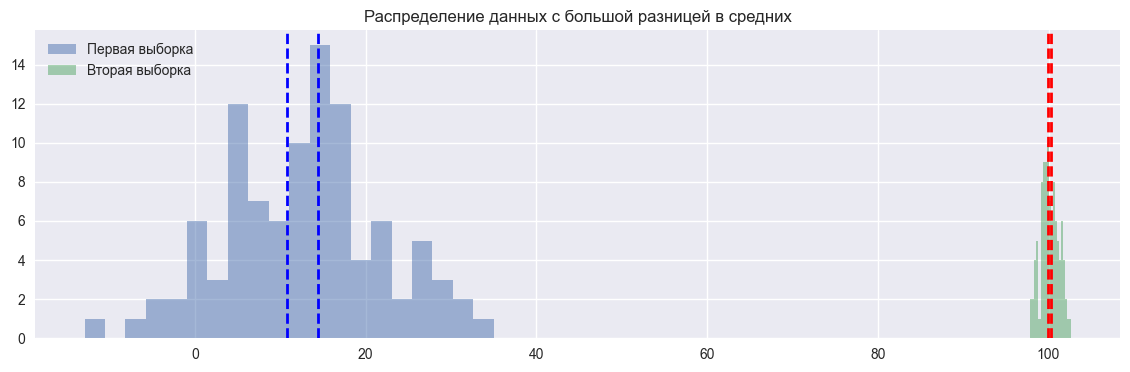

In [12]:
data_fst = np.random.normal(10.5, 10, size=100)
data_snd = np.random.normal(100, 1, size=100)

ci_fst = get_95_interval(data_fst)
ci_snd = get_95_interval(data_snd)

print(f"95% доверительный интервал для среднего первой выборки: {ci_fst}")
print(f"95% доверительный интервал для среднего второй выборки: {ci_snd}")

# Визуализация
plt.figure(figsize=(14, 4))
plt.hist(data_fst, bins=20, alpha=0.5, label='Первая выборка')
plt.hist(data_snd, bins=20, alpha=0.5, label='Вторая выборка')
plt.title('Распределение данных с большой разницей в средних')
plt.axvline(ci_fst[0], color='blue', linestyle='dashed', linewidth=2)
plt.axvline(ci_fst[1], color='blue', linestyle='dashed', linewidth=2)
plt.axvline(ci_snd[0], color='red', linestyle='dashed', linewidth=2)
plt.axvline(ci_snd[1], color='red', linestyle='dashed', linewidth=2)
plt.legend()
plt.show()

Конечно же доверительные интервалы не пересекаются.

Однако, если разница небольшая, то интервалы могут пересечься:

95% доверительный интервал для среднего первой выборки: (10.491420045710312, 12.249156647269823)
95% доверительный интервал для среднего второй выборки: (9.78467110576708, 10.15591346832201)


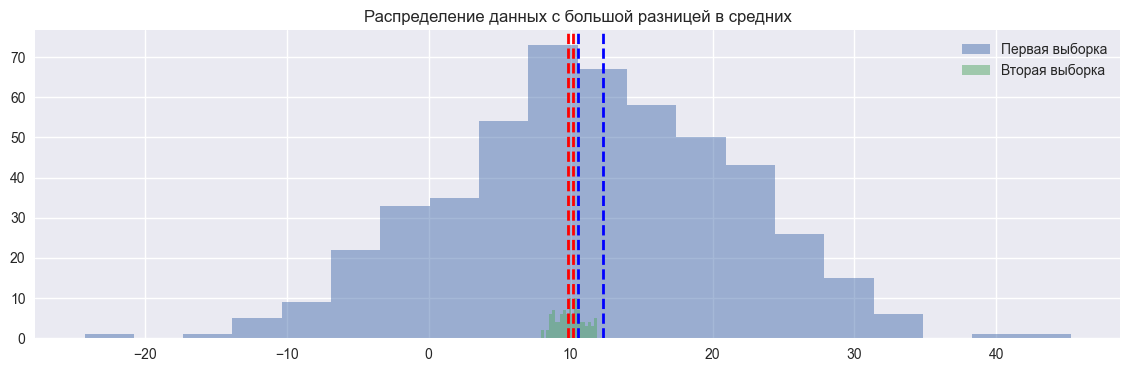

In [13]:
data_fst = np.random.normal(11, 10, size=500)
data_snd = np.random.normal(10, 1, size=100)

ci_fst = get_95_interval(data_fst)
ci_snd = get_95_interval(data_snd)

print(f"95% доверительный интервал для среднего первой выборки: {ci_fst}")
print(f"95% доверительный интервал для среднего второй выборки: {ci_snd}")

# Визуализация
plt.figure(figsize=(14, 4))
plt.hist(data_fst, bins=20, alpha=0.5, label='Первая выборка')
plt.hist(data_snd, bins=20, alpha=0.5, label='Вторая выборка')
plt.title('Распределение данных с большой разницей в средних')
plt.axvline(ci_fst[0], color='blue', linestyle='dashed', linewidth=2)
plt.axvline(ci_fst[1], color='blue', linestyle='dashed', linewidth=2)
plt.axvline(ci_snd[0], color='red', linestyle='dashed', linewidth=2)
plt.axvline(ci_snd[1], color='red', linestyle='dashed', linewidth=2)
plt.legend()
plt.show()

### Оценка критерия

#### Мощность

Давайте посмотрим, как часто такой критерий (доверительные интервалы не пересекаются) будет находить различие в случае, если оно есть. В некотором смысле это мощность критерия

In [14]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(11, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)
    
    lower_fst, upper_fst = get_95_interval(data_fst)
    lower_snd, upper_snd = get_95_interval(data_snd)
    
    count += 1
    if not (lower_fst <= lower_snd <= upper_fst or lower_fst <= upper_snd <= upper_fst):
        hits += 1

print(f"Мощность критерия: {hits / count:.4f}")

Мощность критерия: 0.7187


#### Вероятность ошибки первого рода

Теперь проверим, как часто наш критерий отвергает верную нулевую гипотезу (ошибка первого рода).

In [15]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(10, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)
    
    lower_fst, upper_fst = get_95_interval(data_fst)
    lower_snd, upper_snd = get_95_interval(data_snd)
    
    count += 1
    if not (lower_fst <= lower_snd <= upper_fst or lower_fst <= upper_snd <= upper_fst):
        hits += 1

print(f"Вероятность ошибки первого рода: {hits / count:.4f}")

Вероятность ошибки первого рода: 0.0141


#### Доля обнаруженных различий при малой разнице в средних

Также проверим, как часто различие будет обнаруживаться, если он есть, но очень маленький

In [16]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(10.1, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)
    
    lower_fst, upper_fst = get_95_interval(data_fst)
    lower_snd, upper_snd = get_95_interval(data_snd)
    
    count += 1
    if not (lower_fst <= lower_snd <= upper_fst or lower_fst <= upper_snd <= upper_fst):
        hits += 1

print(f"Доля обнаруженных различий при малой разнице в средних: {hits / count:.4f}")

Доля обнаруженных различий при малой разнице в средних: 0.0206


У нас очень маленькая ошибка первого рода (правда мы хотели 0.05), но мощность тоже небольшая

**Вывод**: этот способ очень прост, но можно использовать более мощные и подконтрольные критерии

### Улучшенный вариант критерия

В простом варианте давайте вычтем две незавимых случайных величины друг из друга

$\mathcal{N}(a_1, \sigma_1^2) - \mathcal{N}(a_2, \sigma_2^2) \sim \mathcal{N}(a_1 - a_2, \sigma_1^2 + \sigma_2^2)$ 

То есть в нашем случае $\frac{\sum\limits_{i=1}^{n^1} \xi_i^1}{n^1} - \frac{\sum\limits_{i=1}^{n^2} \xi_i^2}{n^2}$ будет распределена примерно как $\mathcal{N}(E \xi_1^1 - E \xi_1^2, \frac{D \xi_1^1}{n^1} + \frac{D \xi_1^2}{n^2})$

Проверим те же параметры, что и в предыдущем случае

#### Мощность

In [17]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(11, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)
    
    stat = (
        (data_fst.mean() - data_snd.mean()) 
        / 
        np.sqrt(1. * data_fst.std() ** 2 / len(data_fst) + 1. * data_snd.std() ** 2 / len(data_snd))
    )

    count += 1
    if abs(stat) > 1.96:
        hits += 1

print(f"Мощность критерия: {hits / count:.4f}")

Мощность критерия: 0.8518


#### Вероятность ошибки первого рода

In [18]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(10, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)
    
    stat = (
        (data_fst.mean() - data_snd.mean()) 
        / 
        np.sqrt(1. * data_fst.std() ** 2 / len(data_fst) + 1. * data_snd.std() ** 2 / len(data_snd))
    )
    count += 1
    if abs(stat) > 1.96:
        hits += 1

print(f"Вероятность ошибки первого рода: {hits / count:.4f}")

Вероятность ошибки первого рода: 0.0490


#### Доля обнаруженных различий при малой разнице в средних

In [19]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(10.1, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)
    
    stat = (
        (data_fst.mean() - data_snd.mean()) 
        / 
        np.sqrt(1. * data_fst.std() ** 2 / len(data_fst) + 1. * data_snd.std() ** 2 / len(data_snd))
    )
    count += 1
    if abs(stat) > 1.96:
        hits += 1

print(f"Доля обнаруженных различий при малой разнице в средних: {hits / count:.4f}")

Доля обнаруженных различий при малой разнице в средних: 0.0603


Это уже более похоже на то, чего нам бы хотелось

## 3. Статистические тесты в SciPy

Каждый раз писать такие критерии было чересчур, тем более в модуле scipy всё уже есть

Вот например в scipy есть куча различных тестов, в которых уже все формулы написаны и надо просто вызвать функцию. Например для t-теста:

In [20]:
scipy.stats.ttest_ind(data_fst, data_snd).pvalue

0.8939843360919147

### Оценка критерия

Оценим мощность и вероятность ошибки первого рода:

#### Мощность

In [21]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(11, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    count += 1
    if scipy.stats.ttest_ind(data_fst, data_snd).pvalue < 0.05:
        hits += 1

print(f"Мощность t-теста: {hits / count:.4f}")

Мощность t-теста: 0.0009


#### Вероятность ошибки первого рода

In [22]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(10, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    count += 1
    if scipy.stats.ttest_ind(data_fst, data_snd).pvalue < 0.05:
        hits += 1

print(f"Вероятность ошибки первого рода для t-теста: {hits / count:.4f}")

Вероятность ошибки первого рода для t-теста: 0.0000


Как мы видим, и мощность, и вероятность ошибки первого рода близки к нулю.  
Это происходит из-за разных дисперсий в выборках. Учтем это с помощью параметра equal_var=False

#### Мощность

In [23]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(11, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    count += 1
    if scipy.stats.ttest_ind(data_fst, data_snd, equal_var=False).pvalue < 0.05:
        hits += 1

print(f"Мощность t-теста: {hits / count:.4f}")

Мощность t-теста: 0.8537


#### Вероятность ошибки первого рода

In [24]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(10, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    count += 1
    if scipy.stats.ttest_ind(data_fst, data_snd, equal_var=False).pvalue < 0.05:
        hits += 1

print(f"Вероятность ошибки первого рода для t-теста: {hits / count:.4f}")

Вероятность ошибки первого рода для t-теста: 0.0506


Так уже намного лучше. Итак, это работает примерно как и ЦПТ, только не надо париться с формулами

### Тест Манна-Уитни

Давайте другой тест возьмём, например, Мана-Уитни.  
Тест Манна-Уитни - это непараметрический тест, который не предполагает нормального распределения данных. Он может быть более устойчивым к выбросам, чем t-тест.

#### Мощность

In [25]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(11, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    count += 1
    if scipy.stats.mannwhitneyu(data_fst, data_snd, alternative='two-sided').pvalue < 0.05:
        hits += 1

print(f"Мощность теста Манна-Уитни: {hits / count:.4f}")

Мощность теста Манна-Уитни: 0.1044


#### Вероятность ошибки первого рода

In [26]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(10, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    count += 1
    if scipy.stats.mannwhitneyu(data_fst, data_snd, alternative='two-sided').pvalue < 0.05:
        hits += 1

print(f"Вероятность ошибки первого рода для теста Манна-Уитни: {hits / count:.4f}")

Вероятность ошибки первого рода для теста Манна-Уитни: 0.0001


Немного изменим средние:

In [27]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(0, 10, size=1000)
    data_snd = np.random.normal(0, 1, size=100)

    count += 1
    if scipy.stats.mannwhitneyu(data_fst, data_snd, alternative='two-sided').pvalue < 0.05:
        hits += 1

print(f"Вероятность ошибки первого рода для теста Манна-Уитни: {hits / count:.4f}")

Вероятность ошибки первого рода для теста Манна-Уитни: 0.0004


Думаете всё сломалось? Нет, просто у этого критерия другая нулевая гипотеза!

#### Мощность

In [28]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(0, 1, size=1000)
    data_snd = np.random.normal(1, 1, size=100)

    count += 1
    if scipy.stats.mannwhitneyu(data_fst, data_snd, alternative='two-sided').pvalue < 0.05:
        hits += 1

print(f"Мощность теста Манна-Уитни: {hits / count:.4f}")

Мощность теста Манна-Уитни: 1.0000


#### Вероятность ошибки первого рода

In [29]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(0, 1, size=1000)
    data_snd = np.random.normal(0, 1, size=100)

    count += 1
    if scipy.stats.mannwhitneyu(data_fst, data_snd, alternative='two-sided').pvalue < 0.05:
        hits += 1

print(f"Вероятность ошибки первого рода для теста Манна-Уитни: {hits / count:.4f}")

Вероятность ошибки первого рода для теста Манна-Уитни: 0.0515


# 4. О смысле p-value, корректности и мощности

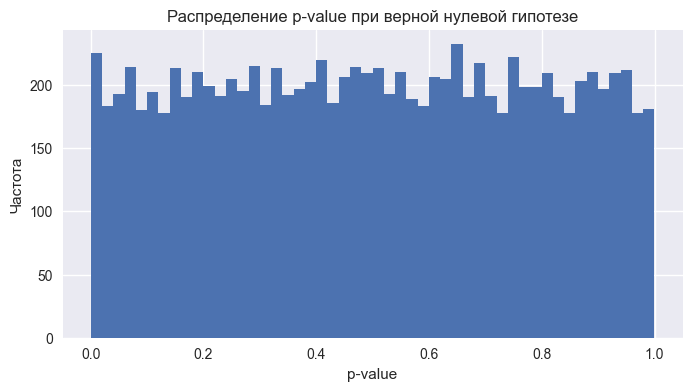

In [30]:
pvalues = []
for _ in range(10000):
    data_fst = np.random.normal(10, 10, size=100)
    data_snd = np.random.normal(10, 1, size=100)
    pvalues.append(scipy.stats.ttest_ind(data_fst, data_snd).pvalue)
    
plt.figure(figsize=(8, 4))
plt.hist(pvalues, bins=50)
plt.title('Распределение p-value при верной нулевой гипотезе')
plt.xlabel('p-value')
plt.ylabel('Частота')
plt.show()

Корректность критерия

In [28]:
bad_pvalues = []
for _ in range(10000):
    data_fst = np.random.normal(10, 10, size=100)
    data_snd = np.random.normal(10, 1, size=100)
    bad_pvalues.append(scipy.stats.ttest_ind(data_fst, data_snd).pvalue < 0.05)
    
print(np.mean(bad_pvalues))

0.0521


Мощность критерия

0.1674


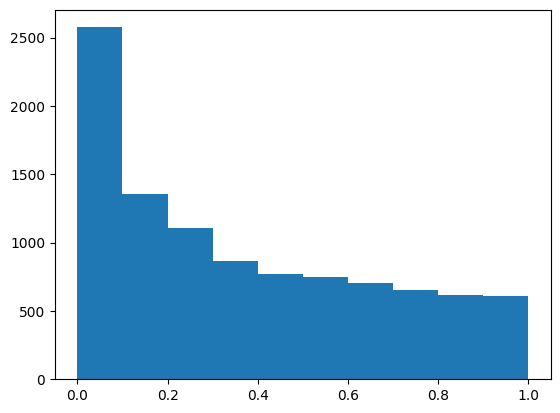

In [29]:
pvalues = []
for _ in range(10000):
    data_fst = np.random.normal(11, 10, size=100)
    data_snd = np.random.normal(10, 1, size=100)
    pvalues.append(scipy.stats.ttest_ind(data_fst, data_snd).pvalue)
    
print((np.array(pvalues) < 0.05).mean())
plt.hist(pvalues)
plt.show()

Усилим различие

0.5156


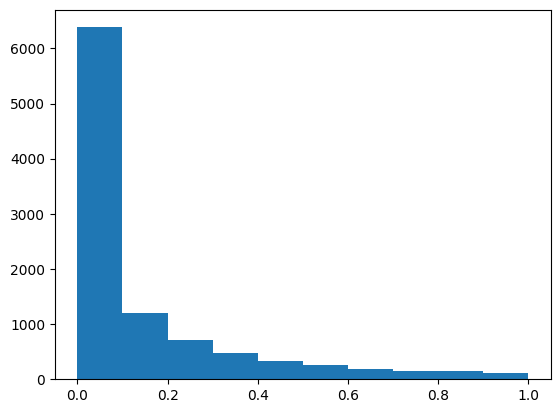

In [30]:
pvalues = []
for _ in range(10000):
    data_fst = np.random.normal(12, 10, size=100)
    data_snd = np.random.normal(10, 1, size=100)
    pvalues.append(scipy.stats.ttest_ind(data_fst, data_snd).pvalue)
    
print((np.array(pvalues) < 0.05).mean())
plt.hist(pvalues)
plt.show()

Увеличим выборку

0.8793


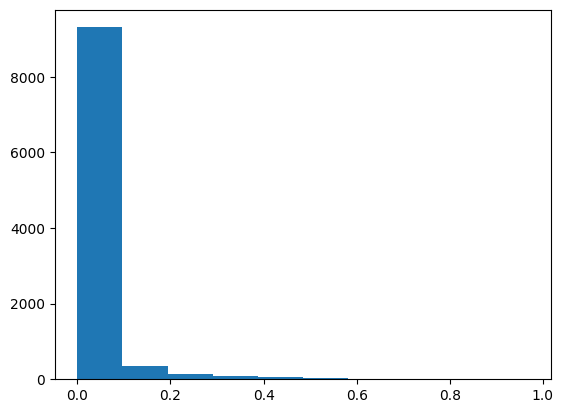

In [31]:
pvalues = []
for _ in range(10000):
    data_fst = np.random.normal(11, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=1000)
    pvalues.append(scipy.stats.ttest_ind(data_fst, data_snd).pvalue)
    
print((np.array(pvalues) < 0.05).mean())
plt.hist(pvalues)
plt.show()

# Перестановочные тесты

In [32]:
def my_test(data_fst, data_snd, iters=1000, plot=True):
    data = np.array(list(data_fst) + list(data_snd))
    size = len(data)
    values = []
    fst_ratio = len(data_fst) * 1. / size
    for _ in range(iters):
        mask = (np.random.random(size=size) < fst_ratio)
        values.append(data[mask].mean() - data[~mask].mean())
        
    if plot:
        plt.hist(values, bins=30)
        plt.show()
        
    return (np.abs(values) > np.abs(data_fst.mean() - data_snd.mean())).mean()

### Корректно ли такое применение?

0.9492018346075748


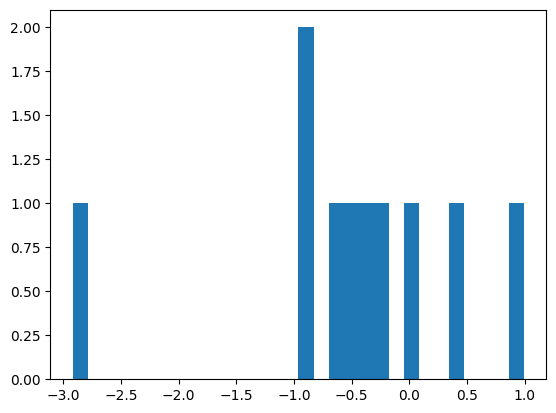

0.9


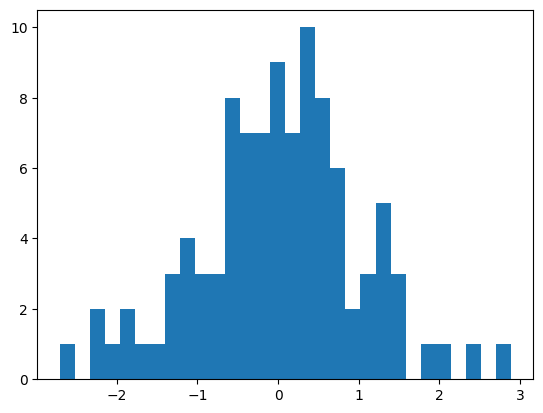

0.93


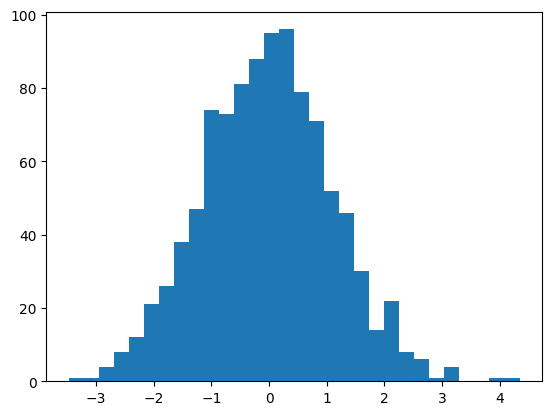

0.951


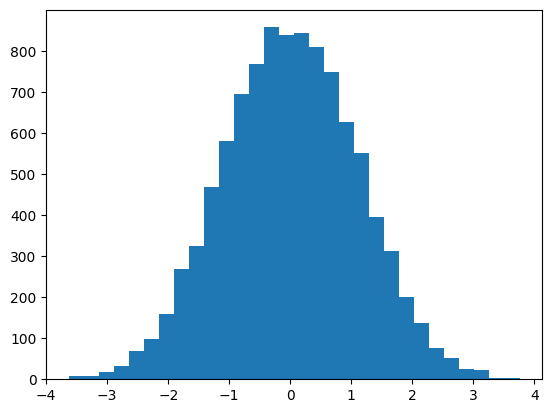

0.952


In [33]:
data_fst = np.random.normal(0, 10, size=100)
data_snd = np.random.normal(0, 1, size=100)

print(scipy.stats.ttest_ind(data_fst, data_snd).pvalue)
print(my_test(data_fst, data_snd, iters=10))
print(my_test(data_fst, data_snd, iters=100))
print(my_test(data_fst, data_snd, iters=1000))
print(my_test(data_fst, data_snd, iters=10000))

0.6532747255193988


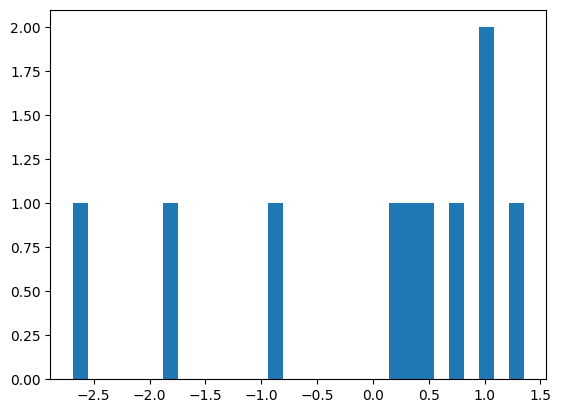

0.8


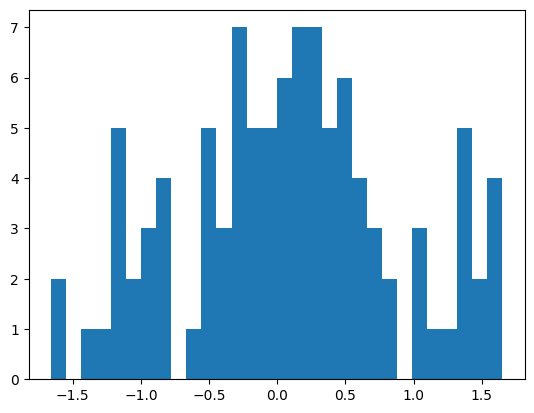

0.57


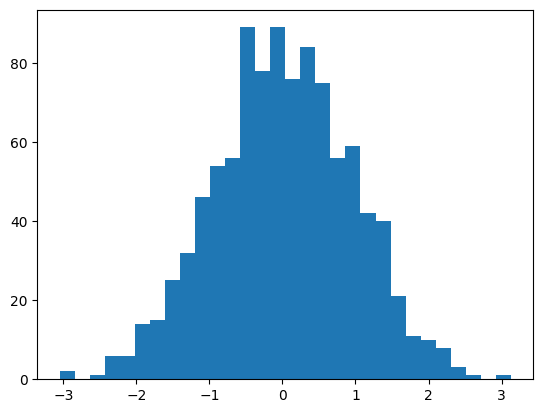

0.668


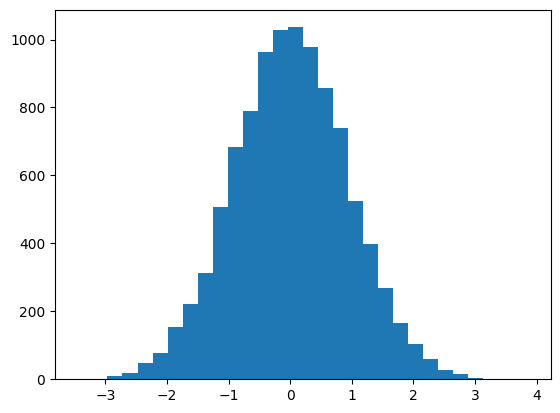

0.656


In [34]:
data_fst = np.random.normal(0, 10, size=100)
data_snd = np.random.normal(1, 1, size=100)

print(scipy.stats.ttest_ind(data_fst, data_snd).pvalue)
print(my_test(data_fst, data_snd, iters=10))
print(my_test(data_fst, data_snd, iters=100))
print(my_test(data_fst, data_snd, iters=1000))
print(my_test(data_fst, data_snd, iters=10000))

К сожалению нет :(

Давайте в этом убедимся :(

In [35]:
hits = 0.
count = 0.

for _ in range(1000):
    data_fst = np.random.normal(11, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    count += 1
    if my_test(data_fst, data_snd, plot=False, iters=1000) < 0.05:
        hits += 1

print(hits / count)

0.001


In [36]:
hits = 0.
count = 0.

for _ in range(1000):
    data_fst = np.random.normal(10, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    count += 1
    if my_test(data_fst, data_snd, plot=False, iters=1000) < 0.05:
        hits += 1

print(hits / count)

0.0


Как с Мана-Уитни, нулевая гипотеза это что распределения совпадают

In [37]:
hits = 0.
count = 0.

for _ in range(1000):
    data_fst = np.random.normal(11, 1, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    count += 1
    if my_test(data_fst, data_snd, plot=False, iters=1000) < 0.05:
        hits += 1

print(hits / count)

1.0


In [38]:
hits = 0.
count = 0.

for _ in range(1000):
    data_fst = np.random.normal(10, 1, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    count += 1
    if my_test(data_fst, data_snd, plot=False, iters=1000) < 0.05:
        hits += 1

print(hits / count)

0.04


Вот это уже неплохо

# Bootstrap

In [39]:
def my_bootstrap(data_fst, data_snd, iters=1000, plot=True):
    values = []
    for _ in range(iters):
        values.append(
            np.random.choice(data_fst, replace=True, size=len(data_fst)).mean()
            -
            np.random.choice(data_snd, replace=True, size=len(data_snd)).mean()
        )
        
    if plot:
        plt.hist(values, bins=30)
        plt.show()
        
    return np.percentile(values, [2.5, 97.5])

0.5591941635203057


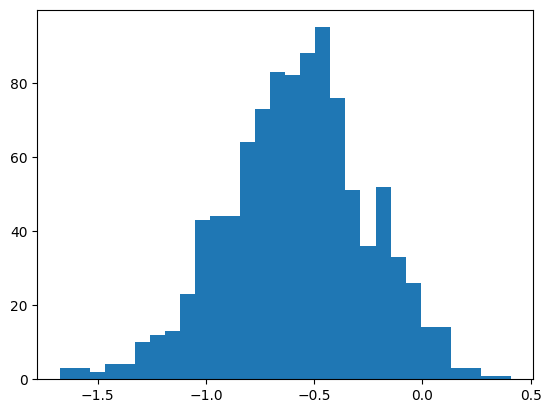

[-1.25976274  0.04066607]


In [40]:
data_fst = np.random.normal(0, 10, size=1000)
data_snd = np.random.normal(0, 1, size=100)

print(scipy.stats.ttest_ind(data_fst, data_snd).pvalue)
print(my_bootstrap(data_fst, data_snd, iters=1000, plot=True))

0.5221545609668234


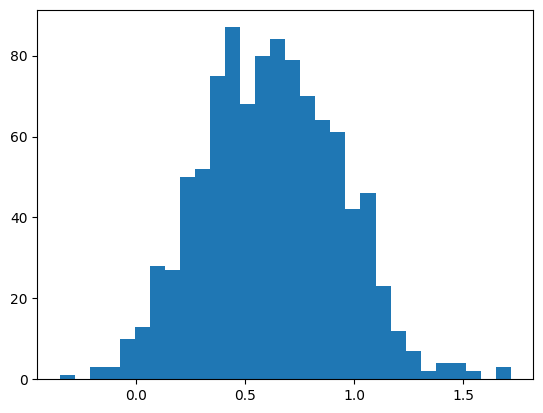

[0.05200041 1.20057924]


In [41]:
data_fst = np.random.normal(1, 10, size=1000)
data_snd = np.random.normal(0, 1, size=100)

print(scipy.stats.ttest_ind(data_fst, data_snd).pvalue)
print(my_bootstrap(data_fst, data_snd, iters=1000, plot=True))

In [42]:
hits = 0.
count = 0.

for _ in range(1000):
    data_fst = np.random.normal(11, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    lower, upper = my_bootstrap(data_fst, data_snd, plot=False, iters=1000)
    count += 1
    if not (lower < 0 < upper):
        hits += 1

print(hits / count)

0.875


In [43]:
hits = 0.
count = 0.

for _ in range(1000):
    data_fst = np.random.normal(10, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    lower, upper = my_bootstrap(data_fst, data_snd, plot=False, iters=1000)
    count += 1
    if not (lower < 0 < upper):
        hits += 1

print(hits / count)

0.049


# Бакетное сэмплирование

In [44]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(10, 5, size=10000)
    data_snd = np.random.normal(10, 1, size=10000)
    
    count += 1
    if scipy.stats.ttest_ind(data_fst, data_snd, equal_var=False).pvalue < 0.05:
        hits += 1

print(hits / count)

0.0532


In [45]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(10.1, 5, size=10000)
    data_snd = np.random.normal(10, 1, size=10000)
    
    count += 1
    if scipy.stats.ttest_ind(data_fst, data_snd, equal_var=False).pvalue < 0.05:
        hits += 1

print(hits / count)

0.5014


делаем бакеты

In [46]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(10, 5, size=10000).reshape((100, 100)).mean(axis=1)
    data_snd = np.random.normal(10, 1, size=10000).reshape((100, 100)).mean(axis=1)
    
    count += 1
    if scipy.stats.ttest_ind(data_fst, data_snd, equal_var=False).pvalue < 0.05:
        hits += 1

print(hits / count)

0.048


In [47]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(10.1, 5, size=10000).reshape((100, 100)).mean(axis=1)
    data_snd = np.random.normal(10, 1, size=10000).reshape((100, 100)).mean(axis=1)
    
    count += 1
    if scipy.stats.ttest_ind(data_fst, data_snd, equal_var=False).pvalue < 0.05:
        hits += 1

print(hits / count)

0.4922


Можно и суммы

In [48]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(10, 5, size=10000).reshape((100, 100)).sum(axis=1)
    data_snd = np.random.normal(10, 1, size=10000).reshape((100, 100)).sum(axis=1)
    
    count += 1
    if scipy.stats.ttest_ind(data_fst, data_snd, equal_var=False).pvalue < 0.05:
        hits += 1

print(hits / count)

0.0531


In [49]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(10.1, 5, size=10000).reshape((100, 100)).sum(axis=1)
    data_snd = np.random.normal(10, 1, size=10000).reshape((100, 100)).sum(axis=1)
    
    count += 1
    if scipy.stats.ttest_ind(data_fst, data_snd, equal_var=False).pvalue < 0.05:
        hits += 1

print(hits / count)

0.4945


А теперь усложним выборку

In [50]:
hits = 0.
count = 0.

for _ in range(10000):
    params_fst = np.random.uniform(-5, 5, size=1000)
    params_snd = np.random.uniform(-5, 5, size=1000)
    
    data_fst = np.random.normal(10, 5, size=10000).reshape((1000, 10)) + params_fst[:, np.newaxis]
    data_fst = data_fst.reshape((10000,))
    data_snd = np.random.normal(10, 1, size=10000).reshape((1000, 10)) + params_snd[:, np.newaxis]
    data_snd = data_snd.reshape((10000,))
    
    count += 1
    if scipy.stats.ttest_ind(data_fst, data_snd, equal_var=False).pvalue < 0.05:
        hits += 1

print(hits / count)

0.352


In [51]:
hits = 0.
count = 0.

for _ in range(10000):
    params_fst = np.random.uniform(-1, 1, size=1000)
    params_snd = np.random.uniform(-1, 1, size=1000)
    
    data_fst = np.random.normal(10.1, 5, size=10000).reshape((1000, 10)) + params_fst[:, np.newaxis]
    data_fst = data_fst.reshape((10000,))
    data_snd = np.random.normal(10, 1, size=10000).reshape((1000, 10)) + params_snd[:, np.newaxis]
    data_snd = data_snd.reshape((10000,))
    
    count += 1
    if scipy.stats.ttest_ind(data_fst, data_snd, equal_var=False).pvalue < 0.05:
        hits += 1

print(hits / count)

0.485


беда(

In [52]:
hits = 0.
count = 0.

for _ in range(10000):
    params_fst = np.random.uniform(-5, 5, size=1000)
    params_snd = np.random.uniform(-5, 5, size=1000)
    
    data_fst = np.random.normal(10, 5, size=10000).reshape((1000, 10)) + params_fst[:, np.newaxis]
    data_fst = data_fst.reshape((10000,)).reshape((100, 100)).mean(axis=1)
    data_snd = np.random.normal(10, 1, size=10000).reshape((1000, 10)) + params_snd[:, np.newaxis]
    data_snd = data_snd.reshape((10000,)).reshape((100, 100)).mean(axis=1)
    
    count += 1
    if scipy.stats.ttest_ind(data_fst, data_snd, equal_var=False).pvalue < 0.05:
        hits += 1

print(hits / count)

0.0537


In [53]:
hits = 0.
count = 0.

for _ in range(10000):
    params_fst = np.random.uniform(-5, 5, size=1000)
    params_snd = np.random.uniform(-5, 5, size=1000)
    
    data_fst = np.random.normal(10.1, 5, size=10000).reshape((1000, 10)) + params_fst[:, np.newaxis]
    data_fst = data_fst.reshape((10000,)).reshape((100, 100)).mean(axis=1)
    data_snd = np.random.normal(10, 1, size=10000).reshape((1000, 10)) + params_snd[:, np.newaxis]
    data_snd = data_snd.reshape((10000,)).reshape((100, 100)).mean(axis=1)
    
    count += 1
    if scipy.stats.ttest_ind(data_fst, data_snd, equal_var=False).pvalue < 0.05:
        hits += 1

print(hits / count)

0.1097


In [54]:
hits = 0.
count = 0.

for _ in range(10000):
    params_fst = np.random.uniform(-1, 1, size=1000)
    params_snd = np.random.uniform(-1, 1, size=1000)
    
    data_fst = np.random.normal(10.1, 5, size=10000).reshape((1000, 10)) + params_fst[:, np.newaxis]
    data_fst = data_fst.reshape((10000,)).reshape((100, 100)).mean(axis=1)
    data_snd = np.random.normal(10, 1, size=10000).reshape((1000, 10)) + params_snd[:, np.newaxis]
    data_snd = data_snd.reshape((10000,)).reshape((100, 100)).mean(axis=1)
    
    count += 1
    if scipy.stats.ttest_ind(data_fst, data_snd, equal_var=False).pvalue < 0.05:
        hits += 1

print(hits / count)

0.4081


In [55]:
hits = 0.
count = 0.

for _ in range(10000):
    params_fst = np.random.uniform(-10, 10, size=1000)
    params_snd = np.random.uniform(-10, 10, size=1000)
    
    data_fst = np.random.normal(11, 5, size=10000).reshape((1000, 10)) + params_fst[:, np.newaxis]
    data_fst = data_fst.reshape((10000,)).reshape((100, 100)).mean(axis=1)
    data_snd = np.random.normal(10, 1, size=10000).reshape((1000, 10)) + params_snd[:, np.newaxis]
    data_snd = data_snd.reshape((10000,)).reshape((100, 100)).mean(axis=1)
    
    count += 1
    if scipy.stats.ttest_ind(data_fst, data_snd, equal_var=False).pvalue < 0.05:
        hits += 1

print(hits / count)

0.9663
